# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Step 0 : Necessary imports 

In [1]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
import numpy as np

from moviepy.editor import VideoFileClip
from IPython.display import HTML

np.random.seed(42)

%matplotlib inline

In [3]:
# Helper method to get path to save image
def save_image(image_name) :
    path = os.path.join('./output_images',image_name)
    return path

# Helper method to plot two images side by side
def plt_images(img_1, title_1, img_2, title_2, image_name, save=True):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1, cmap = 'gray')
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')
    
    if save :
        path = save_image(image_name)
        f.savefig(path)

## Step 1: Compute the camera calibration using chessboard images

In [4]:
def calibrate_camera(image_path, nx=9, ny=6,display = False):
    """ This method goes over multiple raw images to detect ChessBoard corner points used for calibration

        Args:
            image_path ([type]): path to the image folder used to calibrate the camera
            nx (int): Number of inside corners in x
            ny (int): Number of inside corners in y

        Returns:
            tupple: (objpoints , imgpoints , mtx , dist) from calibration
    """
    
    # Make a list of calibration images
    images = glob.glob(image_path)

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    for fname in images:    
        img = cv2.imread(fname)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
        if display : 
            plt_images(img_1 = img_rgb, title_1 = 'Orginial Image' , 
                       img_2 = img, title_2 = 'Corners Detected', 
                       image_name='calibrated.png')

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        # Camera successfully calibrated.
        print("Camera successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        # Unable to calibrate the camera.
        print("Unable to calibrate the camera.")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return (objpoints , imgpoints , mtx , dist)

In [5]:
# Testing the function
# Start Camera Calibration
calibration = calibrate_camera('./camera_cal/*.*',display = False)

Camera successfully calibrated.


## Step 2: Apply a distortion correction to raw images

In [6]:
def undistort(calibration, img, display=True, read = True):
    """Remove distortion from images

        Args:
            calibration ([type]): [description]
            image ([type]): [description]
            display ([type]): [description]
            read ([type]): [description]

        Returns:
            [type]: [description]
    """
    if read:
        img = cv2.imread(image)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    img_size = (img_rgb.shape[1], img_rgb.shape[0])
    
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img_rgb, calibration[2], calibration[3], None, calibration[2])
    
    if display:
        plt_images(img_1 = img, title_1='Original Image',
                   img_2 = undist, title_2 ='Undistorted Image',
                   image_name = 'undistorted.png')
    return undist 

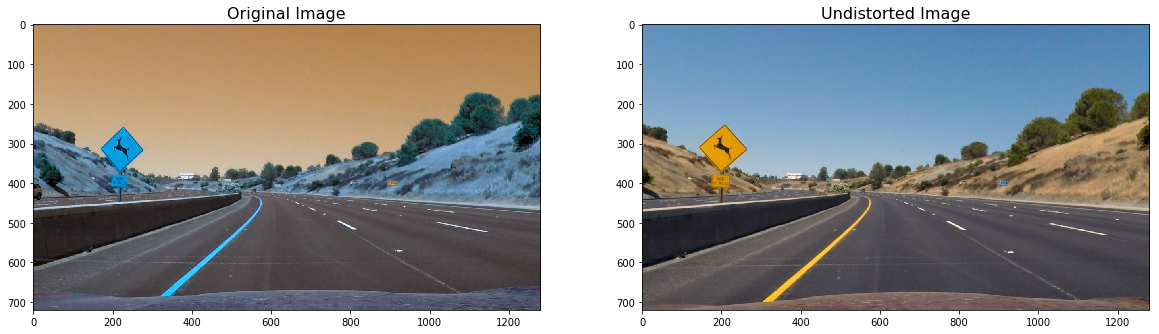

In [7]:
# Testing the function
# Comment out this block for final run

images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(calibration,image)
    break 

## Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.

We need to apply basic image transformation to detect/highlight the lane in the image/video.
We use the following for it -

0. **`Mask Region of Interest in the image`**
1. **`Sobel Filters for edge detection`**
2. **`Gradient Magnitude`**
3. **`Directional Gradient`**
4. **`Color Thresholds in different color spaces`**

#### Step 3.0 : Mask Region of Interest

In [8]:
EPSILON = 0.005
LOWER_LEFT_X = 100
LOWER_LEFT_Y = 720

UPPER_LEFT_X = 400
UPPER_LEFT_Y = 400

UPPER_RIGHT_X = 1000
UPPER_RIGHT_Y = 400

LOWER_RIGHT_X = 1280
LOWER_RIGHT_Y = 720


# Region of Interest
vertices= np.array([[(LOWER_LEFT_X,LOWER_LEFT_Y),
                     (UPPER_LEFT_X, UPPER_LEFT_Y),
                     (UPPER_RIGHT_X, UPPER_RIGHT_Y),
                     (LOWER_RIGHT_X,LOWER_RIGHT_Y)]],dtype=np.int32)


def region_of_interest(img, vertices,display=True):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    if display :
        plt_images(img_1 = undist, title_1 = 'Undistorted Image' , 
               img_2 = masked_image, title_2 = 'Region of Interest', 
               image_name='region_of_interest.png')
        
    return masked_image

def morphological_operation(img,kernel_size = 3 ,display = True) :
    
    
    # 1) Converting to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if display :
        plt_images(img_1 = img, title_1 = 'Undistorted Image' , 
               img_2 = gray, title_2 = 'Gray Scale', 
               image_name='morphed.png')        
    return gray
    

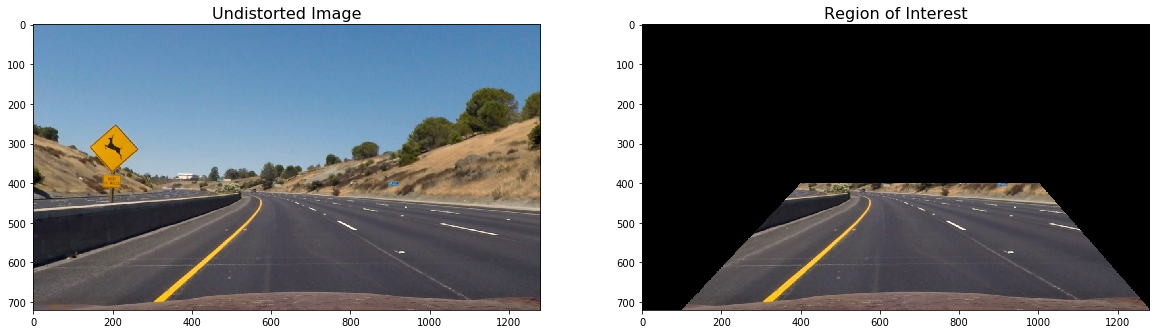

In [9]:
# Testing the function
# Comment out this block for final run
for image in glob.glob('test_images/test*.jpg'):
    undist = undistort(calibration,image,display = False)
    img_region = region_of_interest(undist,vertices) 
    closed = morphological_operation(undist,display = False)
    break

#### Step 3.1: Sobel Filters

In [10]:
# function that applies Sobel x or y, 
#then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100) , display = True):   
    
    # 2) Taking the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(img, cv2.CV_64F, orient=='x', orient=='y')
    
    # 3) Taking the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scaling to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Creating a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    
    if display :
        plt_images(img_1 = img, title_1 = 'Undistorted Image' , 
               img_2 = binary_output, title_2 = 'Sobel Filter ' + orient, 
               image_name='sobel_'+orient+'.png')
        
    return binary_output

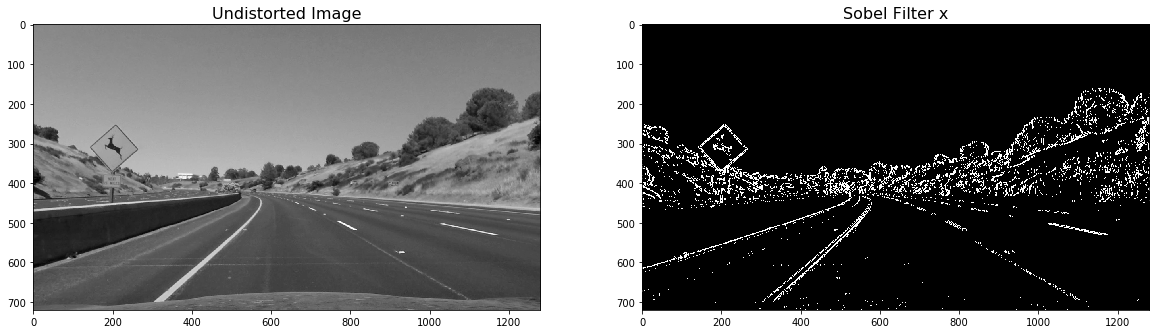

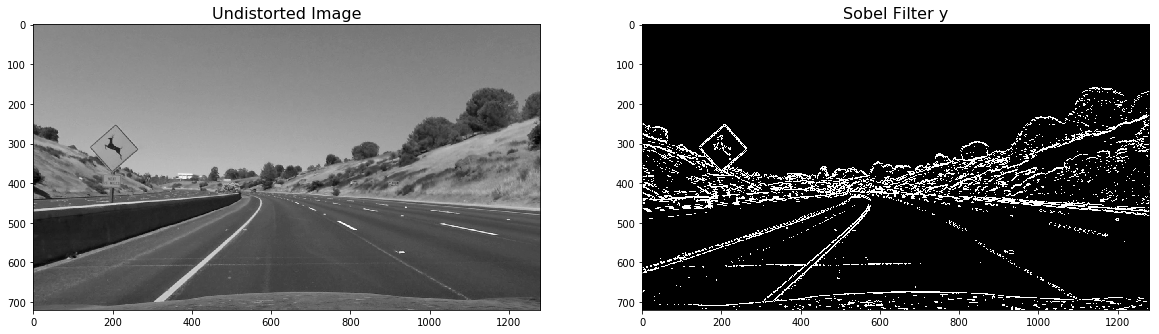

In [11]:
# Testing the function
# Comment out this block for final run
for image in glob.glob('test_images/test*.jpg'):
    undist = undistort(calibration,image,display = False)
    gray_undist = morphological_operation(undist,display = False)
    sobel_x = abs_sobel_thresh(gray_undist,orient='x')
    sobel_y = abs_sobel_thresh(gray_undist,orient='y')
    break

#### Step 4.2: Calculate gradient magnitude

In [12]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100), display = True) :
    
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) 
    
    if display :
        plt_images(img_1 = img, title_1 = 'Undistorted Image' , 
               img_2 = binary_output, title_2 = 'Gradient Magnitude', 
               image_name='gradient_magnitude.png')
    
    return binary_output

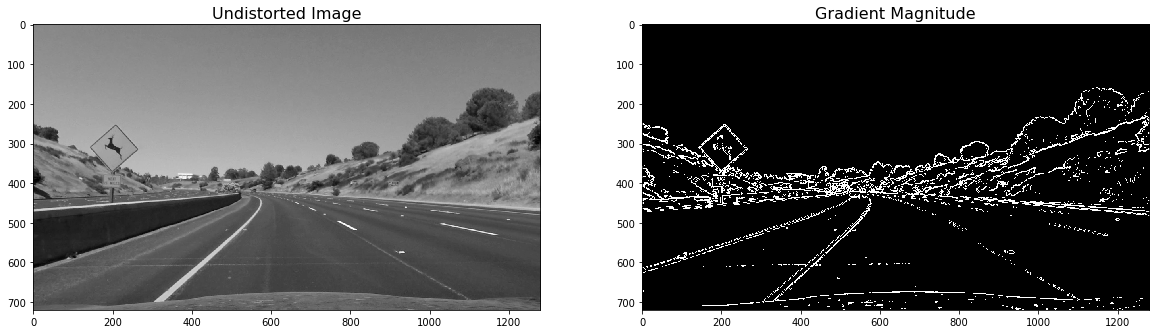

In [13]:
# Testing the function
# Comment out this block for final run
for image in glob.glob('test_images/test*.jpg'):
    undist = undistort(calibration,image,display = False)
    gray_undist = morphological_operation(undist , display = False)
    mag_threshold = mag_thresh(gray_undist)
    break

#### Step 4.3: Calculate directional gradient

In [14]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=15, dir_thresh=(0, np.pi/2), display = True):

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    if display :
        plt_images(img_1 = img, title_1 = 'Undistorted Image' , 
               img_2 = binary_output, title_2 = 'Gradient Direction', 
               image_name='gradient_direction.png')

    # Return the binary image
    return binary_output

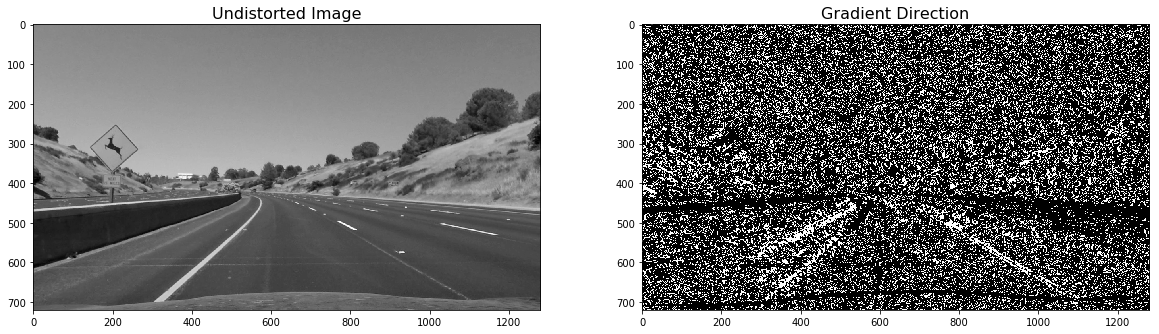

In [15]:
# Testing the function
# Comment out this block for final run
for image in glob.glob('test_images/test*.jpg'):
    undist = undistort(calibration,image,display = False)
    gray_undist = morphological_operation(undist,display = False)
    dir_threshold = dir_thresh(gray_undist,dir_thresh = (0.85, 1.2))
    break

#### Step 4.4: Calculate color threshold

In this step I attempted to convert the warped image to different color spaces and create binary thresholded images which highlight only the lane lines and ignore everything else. I found that the following color channels and thresholds did a good job of identifying the lane lines in the provided test images:

1. The `S Channel` from the `HLS color space`, with a min threshold of 180 and a max threshold of 255, did a fairly good job of identifying both the white and yellow lane lines, but did not pick up 100% of the pixels in either one, and had a tendency to get distracted by shadows on the road.
2. The `L Channel` from the `LUV color space`, with a min threshold of 225 and a max threshold of 255, did an almost perfect job of picking up the white lane lines, but completely ignored the yellow lines.
3. The `B Channel` from the `Lab color space`, with a min threshold of 155 and an upper threshold of 200, did a better job than the S channel in identifying the yellow lines, but completely ignored the white lines.

I chose to create a combined binary threshold based on the three above mentioned binary thresholds, to create one combination thresholded image which does a great job of highlighting almost all of the white and yellow lane lines.

**Note**: The S binary threshold was left out of the final combined binary image and was not used in detecting lane lines because it added extra noise to the binary image and interfered with detecting lane lines accurately.

In [16]:
# Create binary thresholded images to isolate lane line pixels
# expects a undistorted view img in RGB
def apply_color_thresholds(img,hls = False,display=True):       

    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 180
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)    
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # S-Color adds more noise that additional information and hence is not used for the final return
    # Here for the visualization it can been seen
    combined_binary_all = np.zeros_like(s_binary)
    combined_binary_all[(l_binary == 1) | (b_binary == 1) | (s_binary == 1)] = 1


    if display == True:
        
        plt_images(img_1 = img, title_1 = 'Undistorted Image', 
                   img_2 = s_channel, title_2 = 'S-Channel' , 
                   image_name='hls_color.png')

        plt_images(img_1 = b_binary, title_1 = 'B-Channel', 
               img_2 = l_channel, title_2 = 'L-Channel' , 
               image_name='luv_lab_color.png')
        
        plt_images(img_1 = combined_binary, title_1 = 'LUV-Lab-Channel', 
               img_2 = combined_binary_all, title_2 = 'HLS-LUV-Lab-Channel' , 
               image_name='all_color_space.png')
        
    if hls : 
        return combined_binary_all
    return combined_binary

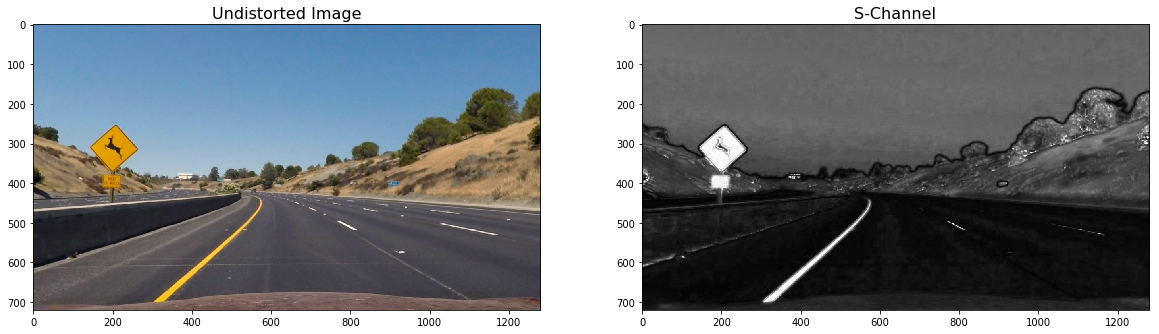

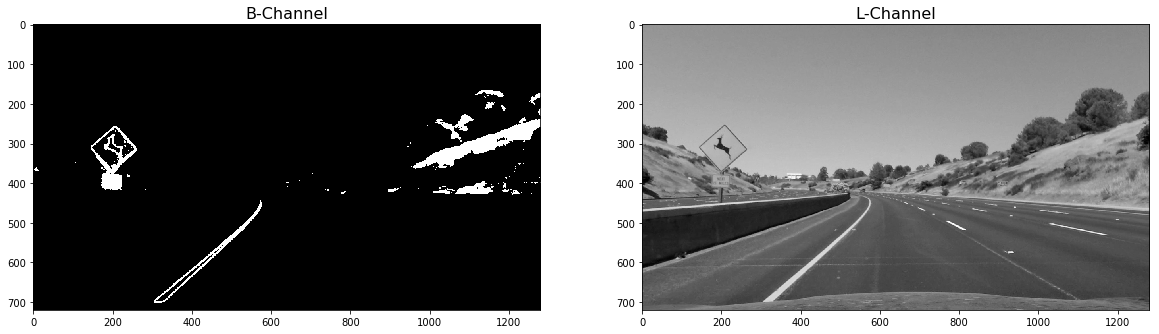

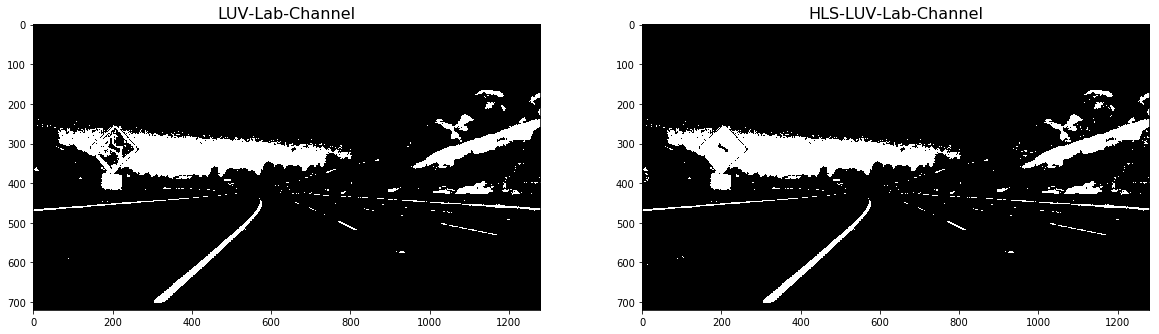

In [17]:
# Testing the function
# Comment out this block for final run
for image in glob.glob('test_images/test*.jpg'):
    # Undistort a test image
    img = cv2.imread(image)
    undist = undistort(calibration,image,display = False)
    combined = apply_color_thresholds(undist, display = True) 
    break 
    

In [18]:
def combine_threshs(binary_gradient_x, binary_gradient_y, binary_grad_mag, binary_grad_dir,
                    binary_color,  ksize=15, display = True):
    
    # Combine the previous thresholds
    combined = np.zeros_like(binary_grad_dir)
    
    combined[((binary_gradient_x == 1) & (binary_gradient_y == 1)) |
             ((binary_grad_mag == 1) & (binary_grad_dir == 1))  |
             (binary_color == 1)] = 1

    return combined

In [19]:
def combine_color_threshs(binary_color, display = True):
    
    # Combine the previous thresholds
    combined = np.zeros_like(binary_color)
    
    combined[(binary_color == 1)] = 1

    return combined

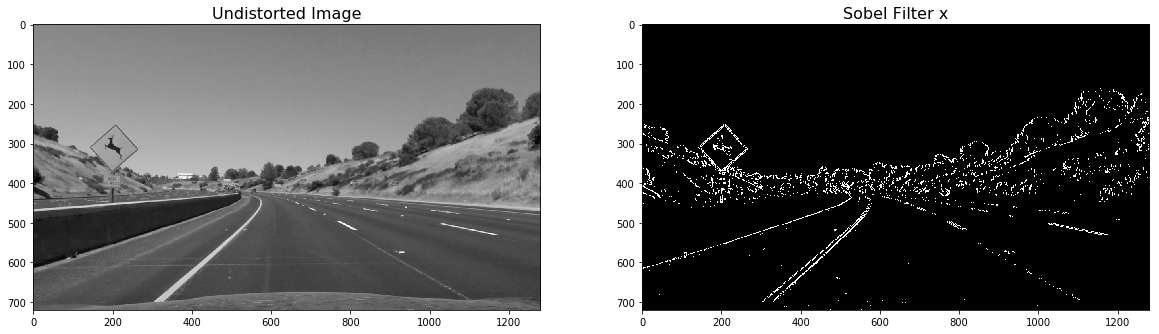

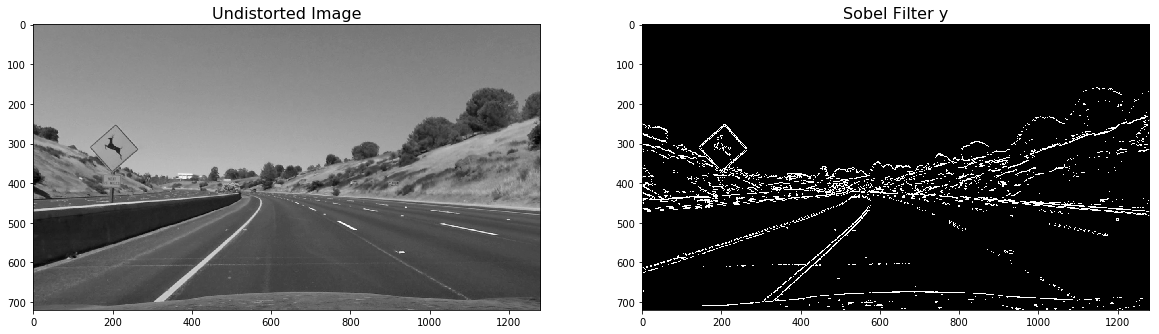

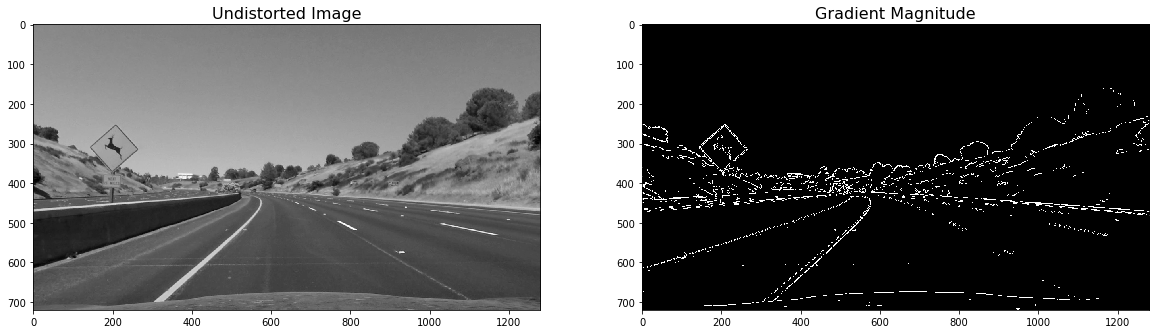

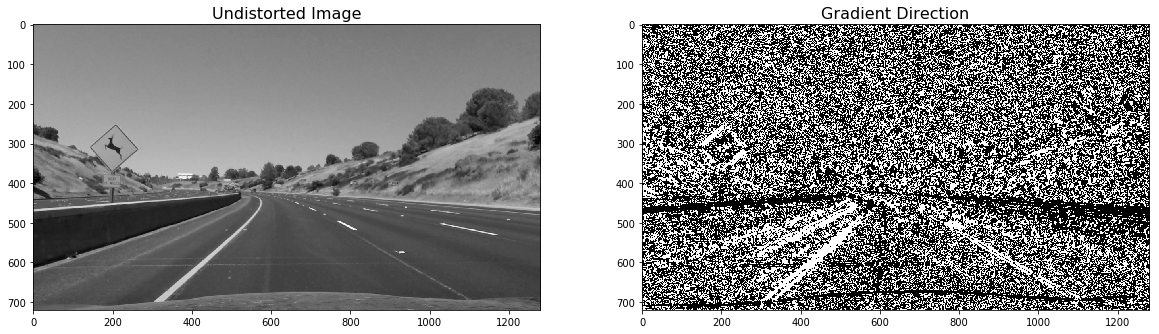

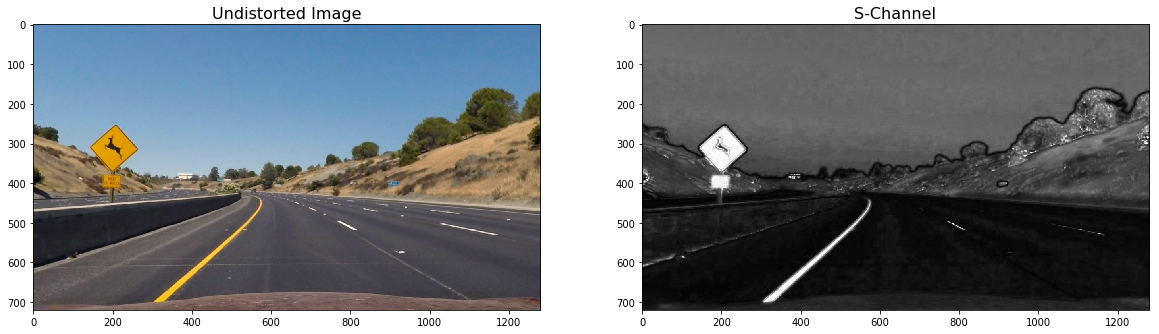

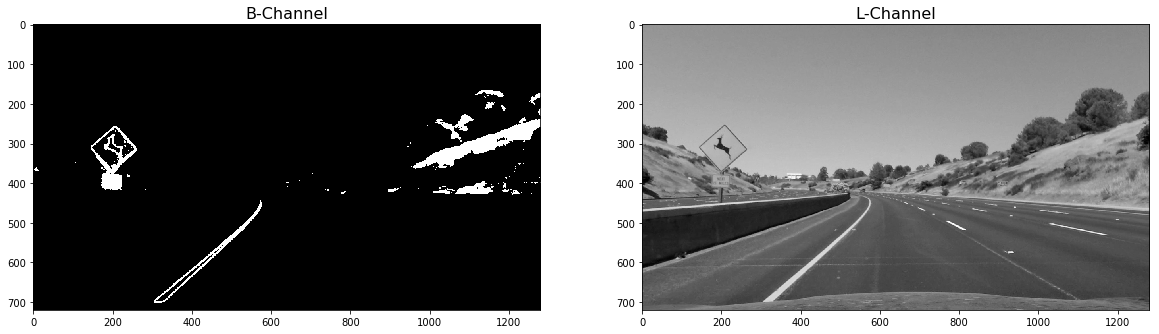

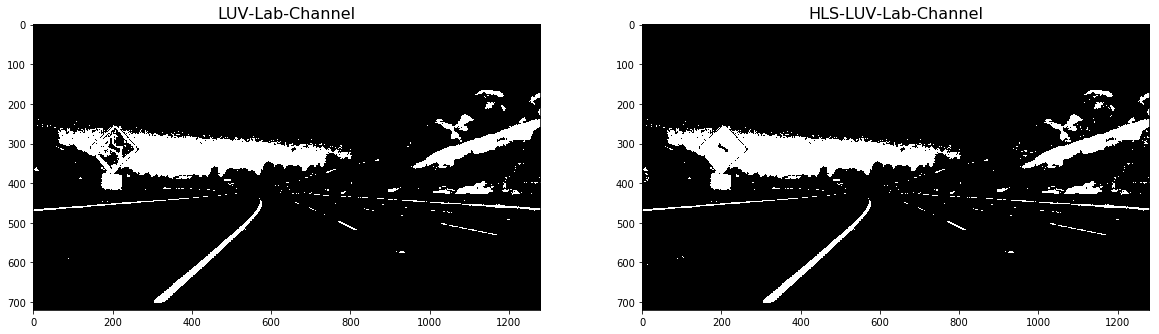

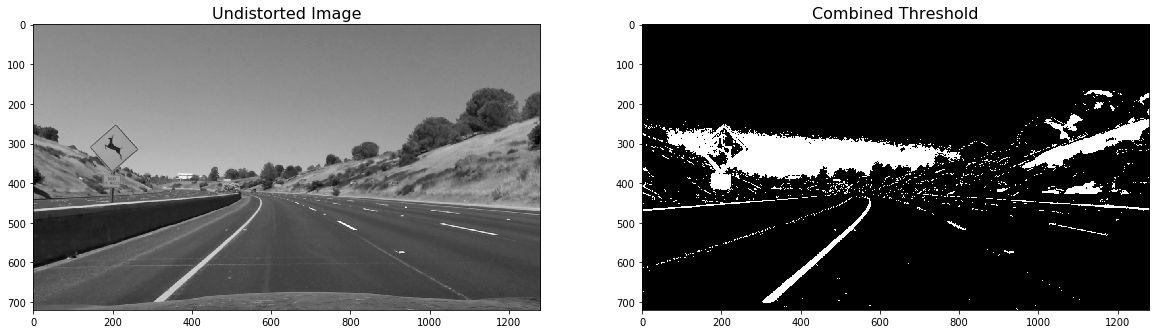

In [20]:
# Testing the function
# Comment out this block for final run
for image in glob.glob('test_images/test*.jpg'):
    
    # Undistort a test image
    img = cv2.imread(image)
    
    undist_color = undistort(calibration,img,display = False, read = False)
    
    undist = morphological_operation(undist_color,display = False)
    # Calculate directional gradient
    grad_x = abs_sobel_thresh(undist, orient='x', sobel_kernel=15, thresh=(30, 100))

    grad_y = abs_sobel_thresh(undist, orient='y', sobel_kernel=15, thresh=(30, 100))

    # Calculate gradient magnitude 
    mag_binary = mag_thresh(undist, sobel_kernel=15, mag_thresh=(50, 100))

    # Calculate gradient direction
    dir_binary = dir_thresh(undist, sobel_kernel=15, dir_thresh=(0.7, 1.3))

    # Calculate color threshold
    col_binary = apply_color_thresholds(undist_color) 
    
    # Combine all the thresholds to identify the lane lines
    combined = combine_threshs(grad_x, grad_y, mag_binary, dir_binary,col_binary, ksize=15) 
    
    plt_images(img_1 = undist, title_1 = 'Undistorted Image', 
               img_2 = combined, title_2 = 'Combined Threshold' , 
               image_name='combined_threshold.png')

    break

## Step 4: Apply a perspective transform to rectify binary image ("birds-eye view")

In [21]:
def birds_eye(img, calibration = None, display=True, read = True):
    """Perform perspective transform

        Args:
            variable1 ([type]): [description]
            variable2 ([type]): [description]

        Returns:
            [type]: [description]
    """
    
    # If calibration is required to undistort the image
    if calibration :
        if read:
            undist = undistort(calibration,img, display = False)
        else:
            undist = undistort(calibration,img, display = False, read=False) 
    else :
        undist = img
    img_size = (undist.shape[1], undist.shape[0])        
    
    offset = 0
    src_coordinates = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst_coordinates = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])

#     src_coordinates = np.float32([[581., 477],[699, 477],
#                       [896, 675],[384, 675]])
#     dst_coordinates = np.float32([[384, 0], [896, 0], 
#                      [896, 720],[384, 720]])

    
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
    warped = cv2.warpPerspective(undist, M, img_size)
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    if display:
        
        plt_images(img_1 = undist, title_1 = 'Undistorted Image', 
               img_2 = warped, title_2 = 'Undistorted and Warped Image' , 
               image_name='birds_eye_view.png')
    
    return warped, M , Minv

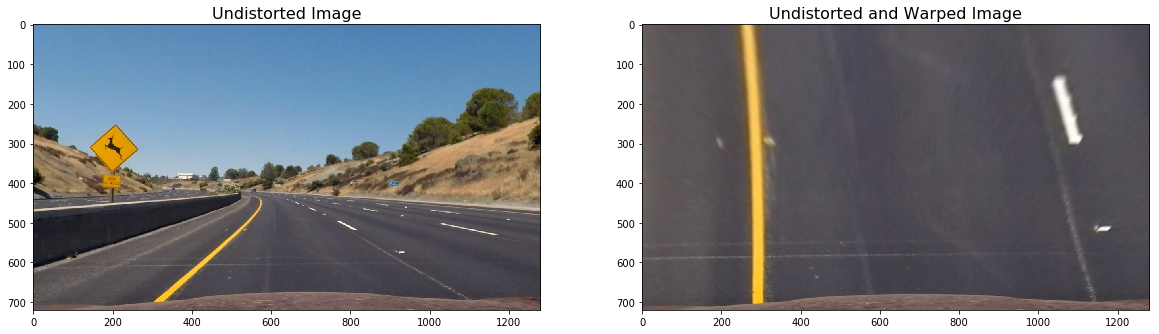

In [22]:
# Testing the function
# Comment out this block for final run
for image in glob.glob('test_images/test*.jpg'):
    undist = undistort(calibration,img,display = False, read = True)
    warped, M , Minv = birds_eye(img = undist,display = True)
    break

### Step 5: Fitting a polynomial to the lane lines

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [23]:
def get_histogram(img, display = True):
    
    histogram  = np.sum(img[img.shape[0]//2:, :], axis=0)
    
    if display :   

        # Plot the results
        plt.title('Histogram', fontsize=16)
        plt.xlabel('Pixel position')
        plt.ylabel('Counts')
        plt.plot(histogram)
        path = save_image('histogram.png')
        plt.savefig(path)
    
    return histogram


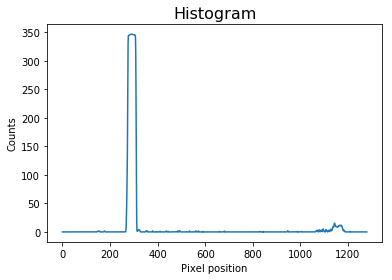

In [24]:
# Testing the function
# Comment out this block for final run
# Run de function over the combined warped image
warped, M , Minv = birds_eye(img = combined,display = False)
histogram = get_histogram(warped)

In [25]:
def detect_lines(img, return_img=False,blind_search = False):
    # Take a histogram of the bottom half of the image
    histogram = get_histogram(img,display = False)

    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))#*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # This changes the parameter in-case Search is after a failure of previous frame detection
    if blind_search  :
        # Set the width of the windows +/- margin
        margin = 200
        # Set minimum number of pixels found to recenter window
        minpix = 20
        # Choose the number of sliding windows
        nwindows = 25
    else :
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Choose the number of sliding windows
        nwindows = 15
        
#     # Set the width of the windows +/- margin
#     margin = 100
#     # Set minimum number of pixels found to recenter window
#     minpix = 50
#     # Choose the number of sliding windows
#     nwindows = 9
    
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base        
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # This change is for Challenge video where some frame detection fails
#     try :
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#     except :
#         return detect_lines(img, return_img,blind_search = True)
        
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int) 

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)


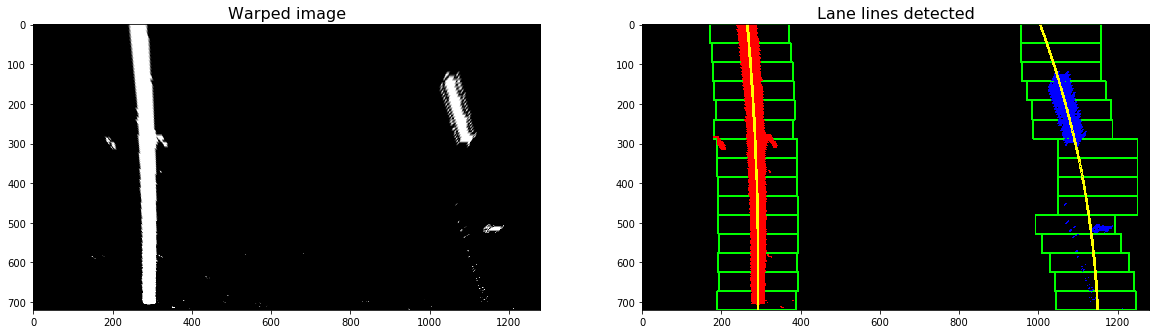

In [26]:
# Testing the function
# Comment out this block for final run

# Run the function
lines_fit, left_points, right_points, out_img = detect_lines(warped, return_img=True)

# Plot the results
plt_images(warped, 'Warped image', out_img, 'Lane lines detected',image_name = 'detect_lines.png')

In [27]:
def detect_similar_lines(img, line_fits=None, return_img=False):
    if line_fits is None:
        return detect_lines(img, return_img)
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the lines could not be found, 
    # perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return detect_lines(img, return_img,blind_search = True)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    if return_img:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))#*255
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(np.uint8) 
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty) 

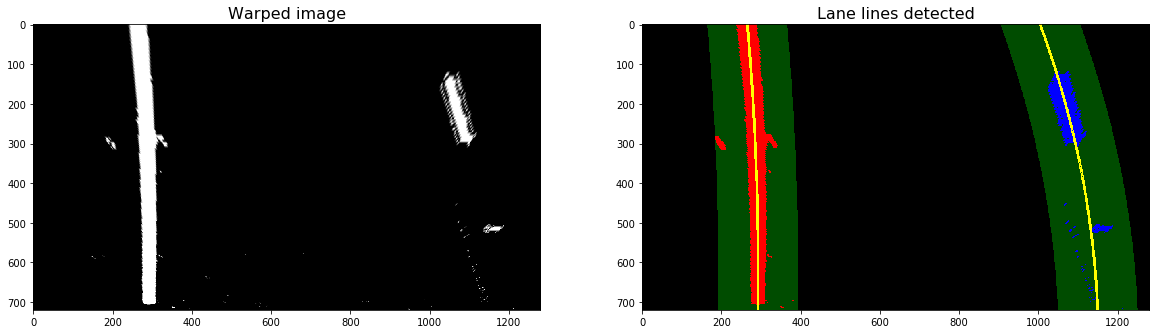

In [28]:
# Run the function
# Notice I am passing the same image than before.
# In a video stream, it should be passed the next frame.
lines_fit, left_points, right_points, out_img  = detect_similar_lines(warped, lines_fit, return_img=True)

# Plot the results
plt_images(warped, 'Warped image', out_img, 'Lane lines detected',image_name = 'similar_detected_lines.png')

### Step 6 : Radis of Curvature

In [29]:
def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [30]:
# Testing the function
# Comment out this block for final run
# Run the function
curvature_rads = curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = combined.shape)

# Print the results
print('Left line curvature:', curvature_rads[0], 'm')
print('Right line curvature:', curvature_rads[1], 'm')

Left line curvature: 1900.8552943622387 m
Right line curvature: 580.7190727286596 m


### Step 7 : Calculating Vehicle Position

In [31]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [32]:
# Testing the function
# Comment out this block for final run
# Run the function
offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)

print ('Car offset from center:', offsetx, 'm.')

Car offset from center: -0.3715340244037501 m.


### Step 8: Warp the detected lane boundaries back onto the original image.

In [33]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

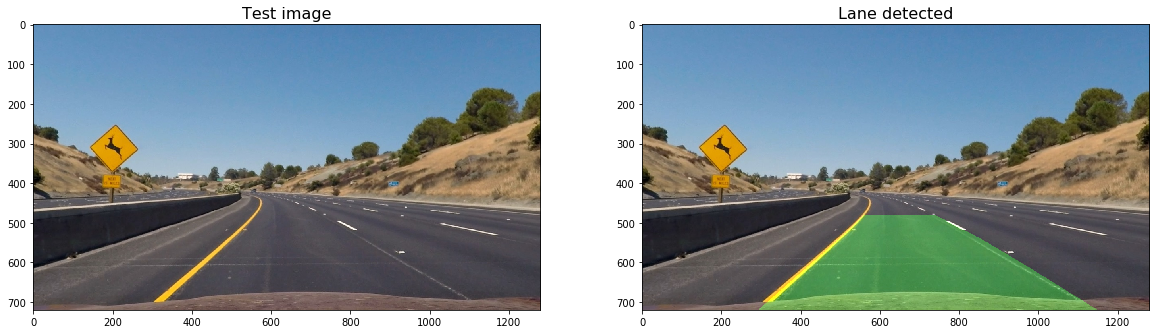

In [34]:
# Testing the function
# Comment out this block for final run

# Run the function
img_lane = draw_lane(undist, warped, left_points, right_points, Minv)

# Plot the results
plt_images(undist, 'Test image', img_lane, 'Lane detected',image_name = 'draw_lane.png')

### Display Metrics

In [35]:
def add_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Calculate radius of curvature
    curvature_rads = curvature_radius(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img , offsetx

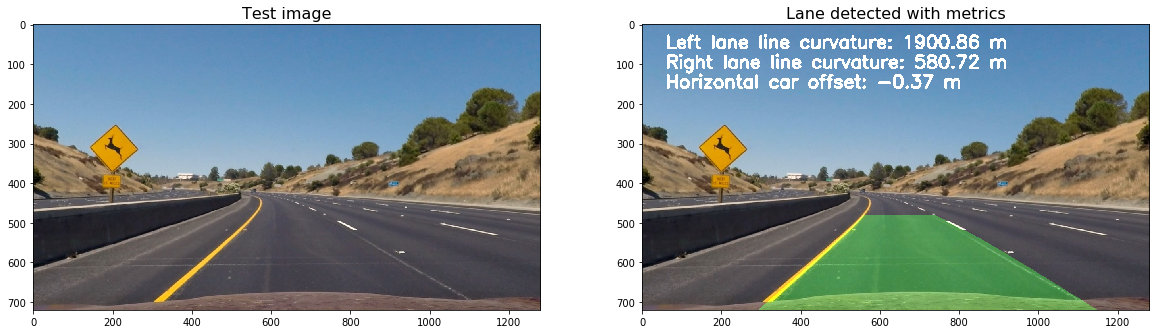

In [36]:
# Testing the function
# Comment out this block for final run
# Run the function
out_img , offsetx = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])

# Plot the results
plt_images(undist, 'Test image', out_img, 'Lane detected with metrics',image_name='add_metrics.png')

# Creating the Pipeline

In [37]:
class ProcessImage:
    def __init__(self, image_path,video =False, display = False):
        # Make a list of calibration images
        #images = glob.glob(images)

        # Calibrate camera
        self.calibration = calibrate_camera(image_path)
        self.lines_fit = None
        
        # For debugging
        self.display = display
        
        # Details to make processing smooth
        self.last_detect = None
        self.video = video
        self.counter = 0

    def __call__(self, img):
        
        self.counter +=1
        
        # Every 3 sec do blind search
        if self.counter == 50 :
            self.lines_fit = None
            self.counter = 0
        
        # Undistord image
        if not self.video :
            undist = undistort(self.calibration, img, display = False , read = False) 
        else :
            undist = cv2.undistort(img, self.calibration[2], self.calibration[3], None, self.calibration[2])
        
        # Fast Processing speeds up in good-lighting
        try :
            
            # Calculate color threshold
            col_binary = apply_color_thresholds(undist, hls = False, display = False) 
            
            # Combine all the thresholds to identify the lane lines
            #combined = combine_threshs(grad_x, grad_y, mag_binary, dir_binary,col_binary, ksize=15) 
            combined = combine_color_threshs(col_binary, display=False) 
            
            # Apply a perspective transform to rectify binary image ("birds-eye view")
            # Since we are passing un-distorted img, calibration note required again
            warped, M , Minv = birds_eye(combined,display = False)  
            self.lines_fit, left_points, right_points, out_img  = detect_similar_lines(warped, self.lines_fit,return_img=True)
            
        except :   
            
            print("Exception Occured at count : {} ".format(self.counter))
            self.lines_fit = None
            #self.counter = 0
            
            img_region_color = region_of_interest(undist,vertices,display = False)        

            # Gray Scale
            img_region = morphological_operation(img_region_color,display = False)

             # Calculate directional gradient
            grad_x = abs_sobel_thresh(img_region, orient='x', sobel_kernel=9, thresh=(30, 100),display = False)

            grad_y = abs_sobel_thresh(img_region, orient='y', sobel_kernel=9, thresh=(30, 100),display = False)

            # Calculate gradient magnitude 
            mag_binary = mag_thresh(img_region, sobel_kernel=15, mag_thresh=(50, 100),display = False)

            # Calculate gradient direction
            dir_binary = dir_thresh(img_region, sobel_kernel=15, dir_thresh=(0.6, 1.3),display = False)           
            
            
            col_binary = apply_color_thresholds(img_region_color, hls = True, display = False) 
            combined = combine_threshs(grad_x, grad_y, mag_binary, dir_binary,col_binary, ksize=15 ,display = False)
            #combined = combine_threshs(col_binary, display=False)
            warped, M , Minv = birds_eye(combined,display = False)  
            self.lines_fit, left_points, right_points, out_img  = detect_similar_lines(warped, self.lines_fit,return_img=True)

            
        # Warp the detected lane boundaries back onto the original image.
        img_lane = draw_lane(undist, warped, left_points, right_points, Minv)
        
        # Add metrics to the output img
        out_img,offsetx = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
        
        
        
        # Perform Blind Search if the car has a highoffset
        if abs(offsetx) > 1.5 :
            self.lines_fit = None            

        
        if self.display :
            plt_images(img_1 = img, title_1 = 'Frame Image', 
               img_2 = out_img, title_2 = 'process_image' , 
               image_name='pipeline.png')
            
            
        return out_img

In [ ]:
# Testing the function
# Comment out this block for final run

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

# Process video frames with our 'process_image' function
img = cv2.imread('test_images/test1.jpg')
process_image(img)

## Project Video

In [38]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'


## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(39,47)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg',video = True)

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

Camera successfully calibrated.
[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


 83%|████████▎ | 1047/1261 [00:54<00:11, 19.38it/s]

Exception Occured at count : 0 
Exception Occured at count : 1 


100%|█████████▉| 1260/1261 [01:05<00:00, 19.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 10min 6s, sys: 6.33 s, total: 10min 13s
Wall time: 1min 5s


In [39]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))

## Challenge Video

In [40]:
input_video = './challenge_video.mp4'
output_video = './challenge_video_solution.mp4'

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg',video = True
                            )

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,10)
clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

Camera successfully calibrated.
[MoviePy] >>>> Building video ./challenge_video_solution.mp4
[MoviePy] Writing video ./challenge_video_solution.mp4


 27%|██▋       | 131/485 [00:06<00:16, 21.10it/s]

Exception Occured at count : 35 


 28%|██▊       | 134/485 [00:06<00:17, 20.43it/s]

Exception Occured at count : 36 
Exception Occured at count : 37 


 28%|██▊       | 136/485 [00:07<00:18, 19.24it/s]

Exception Occured at count : 38 
Exception Occured at count : 39 


 28%|██▊       | 138/485 [00:07<00:19, 18.19it/s]

Exception Occured at count : 40 
Exception Occured at count : 41 


 29%|██▉       | 140/485 [00:08<00:20, 17.23it/s]

Exception Occured at count : 42 


 29%|██▉       | 141/485 [00:08<00:20, 16.78it/s]

Exception Occured at count : 44 


 30%|███       | 147/485 [00:08<00:20, 16.42it/s]

Exception Occured at count : 0 


100%|██████████| 485/485 [00:26<00:00, 18.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_solution.mp4 

CPU times: user 4min 1s, sys: 4.16 s, total: 4min 5s
Wall time: 26.7 s


In [41]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))

## Harder Challenge Video

In [42]:
input_video = './harder_challenge_video.mp4'
output_video = './harder_challenge_video_solution.mp4'

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg',video = True)

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,20)
clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

Camera successfully calibrated.
[MoviePy] >>>> Building video ./harder_challenge_video_solution.mp4
[MoviePy] Writing video ./harder_challenge_video_solution.mp4


 16%|█▋        | 197/1200 [00:11<01:00, 16.62it/s]

Exception Occured at count : 0 


 49%|████▉     | 590/1200 [00:40<00:41, 14.74it/s]

Exception Occured at count : 42 


 50%|████▉     | 598/1200 [00:40<00:40, 14.73it/s]

Exception Occured at count : 2 


 50%|█████     | 604/1200 [00:41<00:40, 14.70it/s]

Exception Occured at count : 7 


 50%|█████     | 606/1200 [00:41<00:40, 14.64it/s]

Exception Occured at count : 9 


 77%|███████▋  | 920/1200 [01:04<00:19, 14.28it/s]

Exception Occured at count : 23 


 77%|███████▋  | 922/1200 [01:04<00:19, 14.25it/s]

Exception Occured at count : 24 
Exception Occured at count : 25 


 77%|███████▋  | 924/1200 [01:05<00:19, 14.17it/s]

Exception Occured at count : 26 
Exception Occured at count : 27 


 77%|███████▋  | 926/1200 [01:05<00:19, 14.09it/s]

Exception Occured at count : 28 


100%|█████████▉| 1199/1200 [01:22<00:00, 14.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_video_solution.mp4 

CPU times: user 10min 10s, sys: 7.42 s, total: 10min 18s
Wall time: 1min 23s


In [43]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))